# Advanced Image Classification with ImageNet

In this assignment, you will be asked to develop a convolutional neural network (CNN) to classify images from the CIFAR-100 dataset. At each step, you'll be guided through the process of developing a model architecture to solve a problem. Your goal is to create a CNN that attains at least 55% accuracy on the validation set.

### The CIFAR-100 Dataset

The [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 500 images from each class.

### Tools

You will use Keras with TensorFlow to develop your CNN. For this assignment, it's strongly recommended that you use a GPU to accelerate your training, or else you might find it difficult to train your network in a reasonable amount of time. If you have a computer with a GPU that you wish to use, you can follow the [TensorFlow instructions](https://www.tensorflow.org/install/) for installing TensorFlow with GPU support. Otherwise, you can use [Google Colab](https://colab.research.google.com/) to complete this assignment. Colab provides free access to GPU-enabled machines. If you run into any issues, please contact us as soon as possible so that we can help you resolve them.

## Task 1: Data Exploration and Preprocessing (Complete or Incomplete)
### 1a: Load and Explore the Dataset
- Use the code below to download the dataset.
- Explore the dataset: examine the shape of the training and test sets, the dimensions of the images, and the number of classes. Show a few examples from the training set.

In [1]:
from keras.datasets import cifar100
from tensorflow.python.platform import build_info as tf_build_info
import tensorflow as tf
print(tf.__version__)

# confirm gpu is available for tensorflow to use
print("GPUs Available:", tf.config.list_physical_devices('GPU'))


# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

2.17.1
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [2]:
# Check dataset shapes
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# Check data types and ranges
print(f"x_train dtype: {x_train.dtype}, y_train dtype: {y_train.dtype}")
print(f"x_train pixel range: {x_train.min()} to {x_train.max()}")
print(f"Unique labels in y_train: {set(y_train.flatten())}")


x_train shape: (50000, 32, 32, 3), y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3), y_test shape: (10000, 1)
x_train dtype: uint8, y_train dtype: int64
x_train pixel range: 0 to 255
Unique labels in y_train: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}


### 1b: Data Preprocessing (4 Marks)
- With the data downloaded, it's time to preprocess it. Start by normalizing the images so that they all have pixel values in the range [0, 1].
- Next, convert the labels to one-hot encoded vectors.
- Finally, split the training set into training and validation sets. Use 80% of the training set for training and the remaining 20% for validation.

In [3]:
from keras.utils import to_categorical

# normalize the images to pixel values in range [0,1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# one-hot encode the labels
y_train = to_categorical(y_train, num_classes=100)
y_test = to_categorical(y_test, num_classes=100)

# improve model generalization through transformations such as flipping, cropping, and rotation when training.
# Define a data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Apply augmentation to the dataset
augmented_images = data_augmentation(x_train)

## Task 2: Model Development (Complete or Incomplete)
### Task 2a: Create a Baseline CNN Model
- Design a CNN architecture. Your architecture should use convolutional layers, max pooling layers, and dense layers. You can use any number of layers, and you can experiment with different numbers of filters, filter sizes, strides, padding, etc. The design doesn't need to be perfect, but it should be unique to you.
- Print out the model summary.

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

model = Sequential([
    Input(shape=(32, 32, 3)),  # Explicitly define the input shape here
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='softmax')  # CIFAR-100 has 100 classes
])

### Task 2b: Compile the model

- Select an appropriate loss function and optimizer for your model. These can be ones we have looked at already, or they can be different.
- Briefly explain your choices (one or two sentences each).
- <b>Loss function:</b> Categorical Crossentropy - it is a standard loss function for multi-class classification problems.
- <b>Optimizer:</b> Adam -  an adaptive learning rate optimizer that combines the benefits of RMSProp and SGD. It adjusts the learning rate dynamically during training, making it well-suited for complex datasets.

In [5]:
from keras import optimizers

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Task 3: Model Training and Evaluation (Complete or Incomplete)
### Task 3a: Train the Model

- Train your model for an appropriate number of epochs. Explain your choice of the number of epochs used - you can change this number before submitting your assignment.
- Use a batch size of 32.
- Use the validation set for validation.

In [11]:
history = model.fit(data_augmentation(x_train), y_train,
          epochs=20, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2918 - loss: 2.8700 - val_accuracy: 0.3283 - val_loss: 2.6885
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3065 - loss: 2.7166 - val_accuracy: 0.3261 - val_loss: 2.6934
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3222 - loss: 2.6554 - val_accuracy: 0.3321 - val_loss: 2.6924
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3333 - loss: 2.5767 - val_accuracy: 0.3370 - val_loss: 2.6406
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3491 - loss: 2.5176 - val_accuracy: 0.3437 - val_loss: 2.6187
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3602 - loss: 2.4463 - val_accuracy: 0.3357 - val_loss: 2.6914
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3694 - loss: 2.3908 - val_accuracy: 0.3535 - val_loss: 2.5946
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3776 - loss: 2.3384 - val_accuracy: 0.

### Task 3b: Accuracy and other relevant metrics on the test set

- Report the accuracy of your model on the test set.
- While accuracy is a good metric, there are many other ways to numerically evaluate a model. Report at least one other metric, and explain what it measures and how it is calculated.

- <b>Accuracy:</b> 0.4791
- <b>Other metric:</b> Top-5 Accuracy
- <b>Reason for selection:</b> Top-5 Accuracy is particularly useful in multi-class classification tasks with a large number of classes, like CIFAR-100. It evaluates how often the true class is among the top 5 predicted probabilities. This may align best with a real-world use case where a close match would be sufficient.
- <b>Value of metric:</b> 0.6279
- <b>Interpretation of metric value:</b> In 62.79% of the test samples, the correct class was in the top 5 predictions. This suggests the model is capturing meaningful patterns but struggling with precise classification.

In [12]:
from keras.metrics import TopKCategoricalAccuracy

# Define the metric
top5_acc = TopKCategoricalAccuracy(k=5)

# Compute Top-5 accuracy on the test set
top5_acc.update_state(y_test, model.predict(x_test))
top5_accuracy_value = top5_acc.result().numpy()

print(f"Top-5 Accuracy: {top5_accuracy_value:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Top-5 Accuracy: 0.6279


### Task 3c: Visualize the model's learning

- Plot the training accuracy and validation accuracy with respect to epochs.
- Select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.
- Briefly discuss the results. What do the plots show? Do the results make sense? What do the classification probabilities indicate?

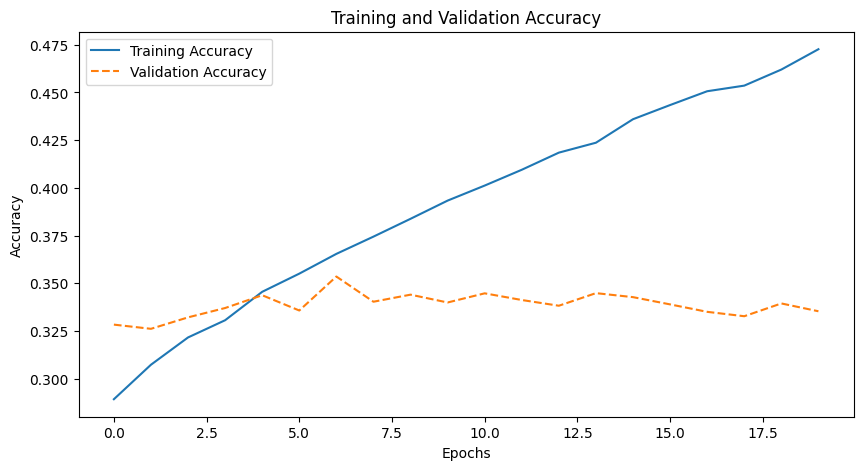

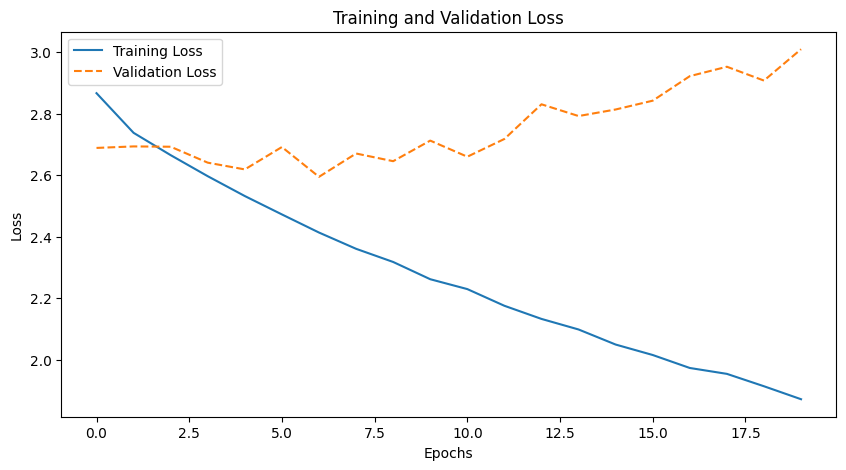

In [19]:
import matplotlib.pyplot as plt

# Extract training history
history_dict = history.history

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


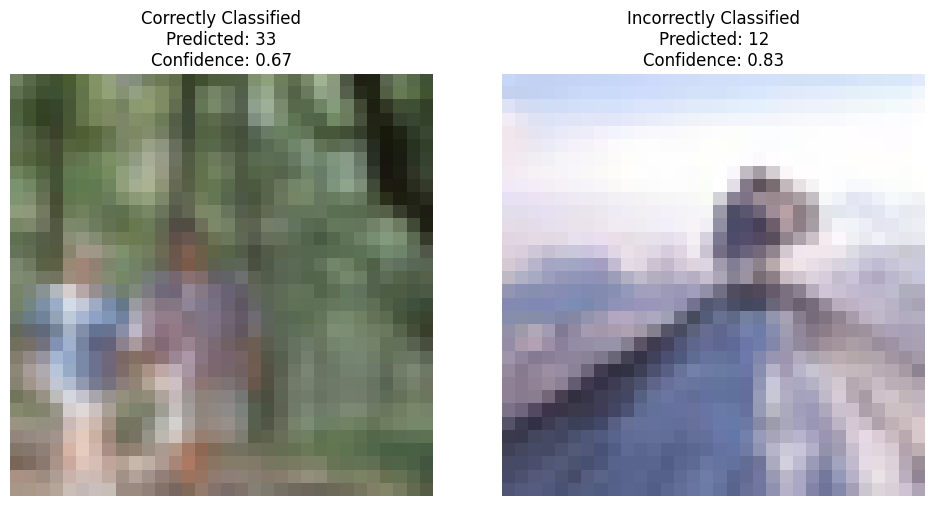

In [20]:
import numpy as np

# Get model predictions
predictions = model.predict(x_test)

# Correctly classified example
correct_idx = np.where(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))[0][0]
correct_image = x_test[correct_idx]
correct_prob = predictions[correct_idx]

# Incorrectly classified example
incorrect_idx = np.where(np.argmax(predictions, axis=1) != np.argmax(y_test, axis=1))[0][0]
incorrect_image = x_test[incorrect_idx]
incorrect_prob = predictions[incorrect_idx]

# Plot the images
plt.figure(figsize=(10, 5))

# Correctly classified image
plt.subplot(1, 2, 1)
plt.imshow(correct_image)
plt.title(f"Correctly Classified\nPredicted: {np.argmax(correct_prob)}\nConfidence: {np.max(correct_prob):.2f}")
plt.axis('off')

# Incorrectly classified image
plt.subplot(1, 2, 2)
plt.imshow(incorrect_image)
plt.title(f"Incorrectly Classified\nPredicted: {np.argmax(incorrect_prob)}\nConfidence: {np.max(incorrect_prob):.2f}")
plt.axis('off')

plt.tight_layout()
plt.show()


What do the plots show?
The accuracy plot shows that training accuracy steadily improves, reaching close to 47%, while validation accuracy plateaus around 33%. This indicates that the model is fitting the training data well but struggles to generalize to unseen data, a sign of overfitting. The loss plot shows training loss decreasing consistently, while validation loss fluctuates and increases toward the end, further indicating overfitting.

Do the results make sense?
Yes, the results make sense given the complexity of the CIFAR-100 dataset, which has 100 classes and relatively small image sizes (32x32). Online information regarding this dataset indicates overfitting is common with such a challenging dataset. The model architecture needs further tuning (e.g., regularization, deeper networks, etc.).

What do the classification probabilities indicate?
For the correctly classified image, the model is fairly confident with 67%. This suggests meaningful features learned for the class. It may yet benefit from further training or regularization for sharper decision boundaries.
For the incorrectly classified image, the model is quite confident (83%) in its wrong prediction. This overconfidence may indicate biases in the model or feature overlaps between classes that lead to incorrect generalizations. Addressing this will require further experimentation.

## Task 4: Model Enhancement (Complete or Incomplete)
### Task 4a: Implementation of at least one advanced technique

- Now it's time to improve your model. Implement at least one technique to improve your model's performance. You can use any of the techniques we have covered in class, or you can use a technique that we haven't covered. If you need inspiration, you can refer to the [Keras documentation](https://keras.io/).
- Explain the technique you used and why you chose it.
- If you used a technique that requires tuning, explain how you selected the values for the hyperparameters.

In [22]:
from keras.layers import BatchNormalization
from keras.regularizers import l2  # Correct import for L2 regularization

# Build an enhanced CNN
enhanced_model = Sequential([
    Input(shape=(32, 32, 3)),  # Explicitly define input shape

    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Third convolutional block (new)
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten and fully connected layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Increased dropout rate
    Dense(100, activation='softmax')  # CIFAR-100 has 100 classes
])

# Compile the model
enhanced_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])


In [23]:
enhanced_history = enhanced_model.fit(
    data_augmentation(x_train), y_train,
    epochs=20, batch_size=64, validation_data=(x_test, y_test)
)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.0649 - loss: 5.2354 - val_accuracy: 0.0927 - val_loss: 4.3927
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1418 - loss: 3.8955 - val_accuracy: 0.2161 - val_loss: 3.4754
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1840 - loss: 3.6294 - val_accuracy: 0.1717 - val_loss: 3.6839
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2070 - loss: 3.4983 - val_accuracy: 0.2107 - val_loss: 3.5000
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2278 - loss: 3.3969 - val_accuracy: 0.2685 - val_loss: 3.2287
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2444 - loss: 3.3230 - val_accuracy: 0.2607 - val_loss: 3.2694
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2607 - loss: 3.2484 - val_accuracy: 0.2935 - val_loss: 3.1049
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2683 - loss: 3.1923 - val_accuracy: 

Explain the technique you used and why you chose it:
I tried two as indicated earlier:

1. Regularization:

L2 regularization was added to the convolutional layers. This penalized large weights, which helped prevent overfitting by encouraging the model to use smaller, more generalizable weights.
Also, the dropout rate in the dense layer was set to 50%. Dropout randomly disables neurons during training, which forces the model to rely on different subsets of neurons and reduces overfitting.

2. Deeper Network:

Added an additional convolutional block with more filters. Deeper networks are better at capturing complex patterns and hierarchical features in data. The thought was this would be useful for a more challenging dataset like this.

If you used a technique that requires tuning, explain how you selected the values for the hyperparameters:

The dropout rate was set to 0.5, a typical value for dense layers in convolutional networks. A good proven starting point.

128 filters were set for the additional convolutional block. Again, a standard practice starting point with the goal of capturing more complex patterns.

### Task 4b: Evaluation of the enhanced model

- Re-train your model using the same number of epochs as before.
- Compare the accuracy and other selected metric on the test set to the results you obtained before.
- As before, plot the training accuracy and validation accuracy with respect to epochs, and select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.

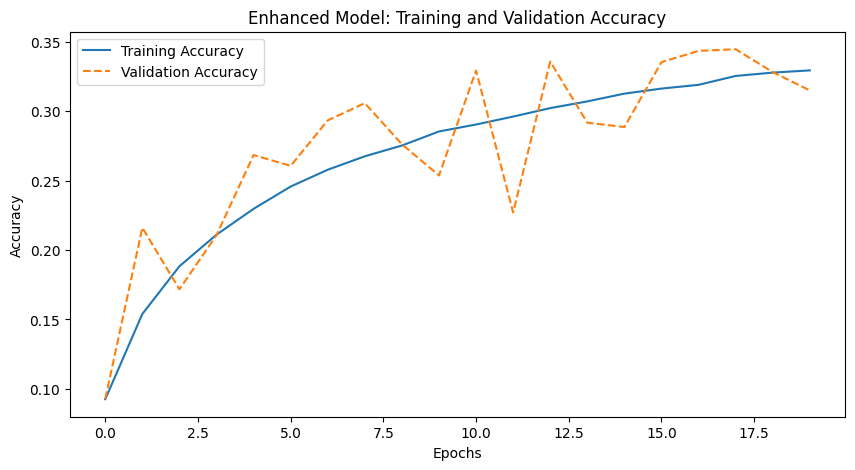

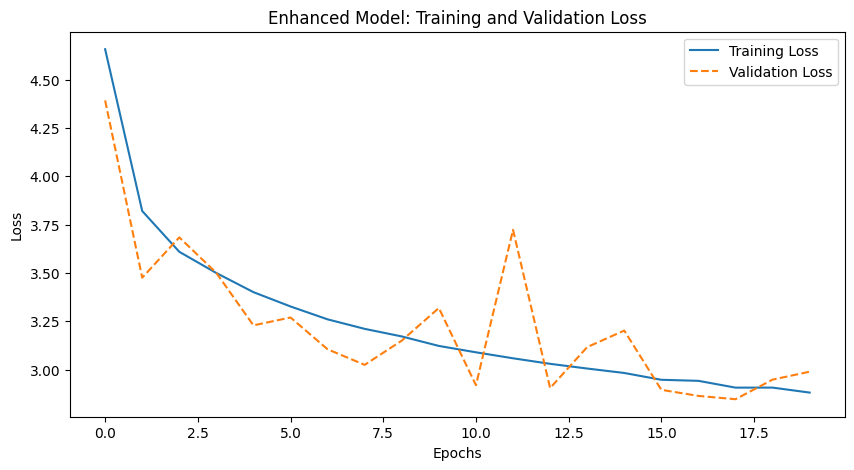

In [26]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(enhanced_history.history['accuracy'], label='Training Accuracy')
plt.plot(enhanced_history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Enhanced Model: Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(enhanced_history.history['loss'], label='Training Loss')
plt.plot(enhanced_history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Enhanced Model: Training and Validation Loss')
plt.legend()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


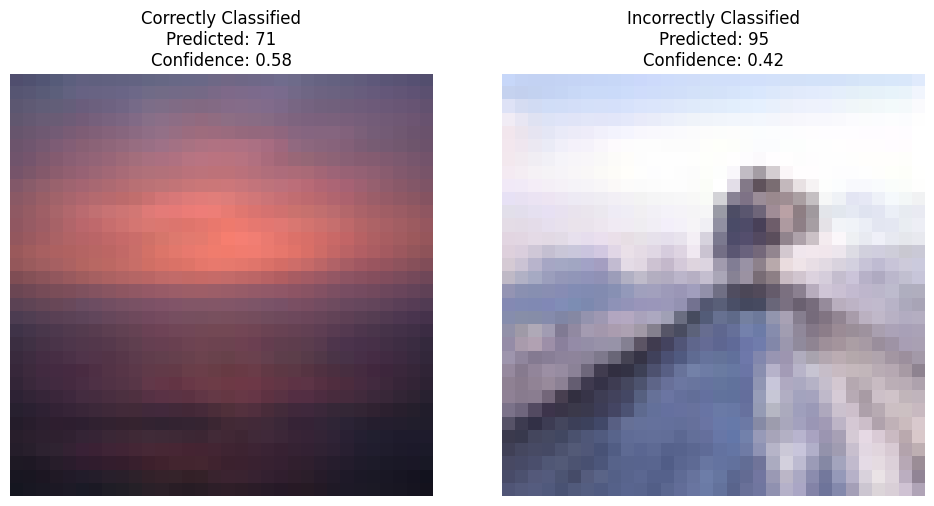

In [27]:
# Get predictions for the enhanced model
enhanced_predictions = enhanced_model.predict(x_test)

# Correctly classified example
correct_idx = np.where(np.argmax(enhanced_predictions, axis=1) == np.argmax(y_test, axis=1))[0][0]
correct_image = x_test[correct_idx]
correct_prob = enhanced_predictions[correct_idx]

# Incorrectly classified example
incorrect_idx = np.where(np.argmax(enhanced_predictions, axis=1) != np.argmax(y_test, axis=1))[0][0]
incorrect_image = x_test[incorrect_idx]
incorrect_prob = enhanced_predictions[incorrect_idx]

# Plot the images
plt.figure(figsize=(10, 5))

# Correctly classified image
plt.subplot(1, 2, 1)
plt.imshow(correct_image)
plt.title(f"Correctly Classified\nPredicted: {np.argmax(correct_prob)}\nConfidence: {np.max(correct_prob):.2f}")
plt.axis('off')

# Incorrectly classified image
plt.subplot(1, 2, 2)
plt.imshow(incorrect_image)
plt.title(f"Incorrectly Classified\nPredicted: {np.argmax(incorrect_prob)}\nConfidence: {np.max(incorrect_prob):.2f}")
plt.axis('off')

plt.tight_layout()
plt.show()


### Task 4c: Discussion of the results

- Briefly discuss the results.
- Did the model's performance improve?
- Why do you think this is?
- Do you think there is room for further improvement? Why or why not?
- What other techniques might you try in the future?
- Your answer should be no more than 200 words.

# Your answer here:
The enhanced model showed a slight improvement in validation accuracy (34.48% vs. 33%) and exhibited more consistent validation loss trends, indicating that overfitting was reduced. These improvements are likely due to the added regularization (L2, dropout) and deeper architecture, which enabled the model to capture more complex features while discouraging reliance on specific neurons or large weights.

Despite this, the validation metrics still fluctuate, and overfitting remains a concern. This suggests the model struggles to generalize well on the CIFAR-100 dataset, which is inherently challenging due to its large number of classes and small image size.

There is room for further improvement. Future enhancements could include transfer learning with pretrained models like ResNet to leverage rich feature representations, stronger data augmentation techniques (e.g., brightness/contrast adjustments or MixUp), and hyperparameter tuning. For example, adjusting the learning rate schedule (starting at 0.001), experimenting with dropout rates (0.3 or 0.6), and tweaking L2 regularization strength (e.g., 0.02 or 0.1) could provide meaningful gains. Testing different batch sizes (e.g., 32 or 128) might also improve training dynamics.

Future efforts should prioritize stabilizing validation performance and achieving better generalization.

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.